In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt

### Load training and testing dataset

In [2]:
def load_dataset(subset="training", seed=42):
    return keras.utils.image_dataset_from_directory(
        "./fish_data",
        label_mode="categorical",
            color_mode="rgb",
        batch_size=64,
        image_size=(512, 512),
        shuffle=True,
        validation_split=0.2,
        seed=seed,
        subset=subset
    )

In [3]:
train_dataset = load_dataset(subset="training")
test_dataset = load_dataset(subset="validation")

Found 1835 files belonging to 20 classes.
Using 1468 files for training.
Found 1835 files belonging to 20 classes.
Using 367 files for validation.


### Display one image from the first batch

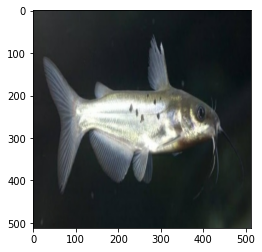

In [18]:
for inputs in train_dataset.take(1):
    imgs, labels = inputs

plt.imshow(tf.cast(imgs[2], tf.dtypes.int32))

### Various Augmentation Layers Implementations

In [4]:
class RandomRotate90(keras.layers.Layer):
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        
        if training is True and tf.random.uniform((1,), minval=0, maxval=2, dtype=tf.dtypes.int32) == 0:
            return tf.image.rot90(inputs)
        else:
            return inputs

class RandomBrightness(keras.layers.Layer):
    def __init__(self, max_delta, **kwargs):
        super().__init__(**kwargs)
        self.max_delta=max_delta
        
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
        
        if training is True:
            return tf.image.random_brightness(inputs, self.max_delta)
        else:
            return inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "max_delta": self.max_delta
        })
        return config

def vectorized_shear_x(inputs, level, fill_value):
    return tf.map_fn(
        lambda inputs, level=level, fill_value=fill_value: tfa.image.shear_x(inputs, level, fill_value),
        inputs,
        parallel_iterations=16
    )
    
class RandomShearX(keras.layers.Layer):
    def __init__(self, level, fill_value=0.0, **kwargs):
        super().__init__(**kwargs)
        self.level=level
        self.fill_value=fill_value
    
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
            
        if training is True:
            level = tf.random.uniform((1,), minval=-self.level, maxval=self.level)
            return vectorized_shear_x(
                inputs, level[0], fill_value=self.fill_value
            )
        else:
            return inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "level": self.level,
            "fill_value": self.fill_value
        })
        return config

def vectorized_shear_y(inputs, level, fill_value):
    return tf.map_fn(
        lambda inputs, level=level, fill_value=fill_value: tfa.image.shear_y(inputs, level, fill_value),
        inputs,
        parallel_iterations=16
    )

class RandomShearY(keras.layers.Layer):
    def __init__(self, level, fill_value=0.0, **kwargs):
        super().__init__(**kwargs)
        self.level=level
        self.fill_value=fill_value
    
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
            
        if training is True:
            level = tf.random.uniform((1,), minval=-self.level, maxval=self.level)
            return vectorized_shear_y(
                inputs, level[0], fill_value=self.fill_value
            )
        else:
            return inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "level": self.level,
            "fill_value": self.fill_value
        })
        return config
    
class RandomCutout(keras.layers.Layer):
    def __init__(self, mask_size, fill_value=0.0, **kwargs):
        super().__init__(**kwargs)
        self.mask_size=mask_size
        self.fill_value=fill_value
        
    def call(self, inputs, training=None):
        if training is None:
            training = keras.backend.learning_phase()
            
        if training is True:
            return tfa.image.random_cutout(inputs, self.mask_size, self.fill_value)
        else:
            return inputs

### Layer for applying random augmentations

In [5]:
class RandomAugmentation(keras.layers.Layer):
    def __init__(self, augmentation, prob, **kwargs):
        super().__init__(**kwargs)
        self.augmentation=augmentation
        self.prob=prob
        
    def call(self, inputs, training=None):
        if tf.random.uniform((1,), 0.0, 1.0) <= self.prob:
            return self.augmentation(inputs, training=training)
        else:
            return inputs
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "augmentation": self.augmentation.get_config(),
            "prob": self.prob
        })
        return config 
            

### Create augmentation layer

In [6]:
def make_aug(fill_value=0.0):
    return keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomContrast(0.99),
        RandomBrightness(95.0),
        keras.layers.RandomTranslation(0, 0.3, fill_mode="constant", fill_value=fill_value),
        keras.layers.RandomTranslation(0.3, 0, fill_mode="constant", fill_value=fill_value),
        keras.layers.RandomRotation(0.5, fill_mode="constant", fill_value=fill_value),
        RandomShearX(0.5, fill_value=fill_value),
        RandomShearY(0.5, fill_value=fill_value),
        keras.layers.RandomZoom(0.5, fill_mode="constant", fill_value=fill_value),
        keras.layers.Resizing(256, 256),
        RandomCutout(tf.constant([32, 32]), fill_value=fill_value),
        RandomCutout(tf.constant([32, 32]), fill_value=fill_value),
        keras.layers.ReLU(max_value=255.0, threshold=0.0)
    ])

### Show the same image from earlier, but augmented

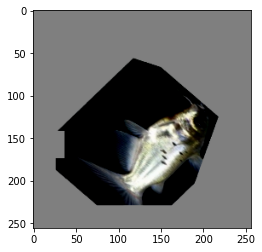

In [273]:
plt.imshow(
    tf.cast(make_aug(fill_value=127.0)(tf.expand_dims(imgs[2], 0), training=True)[0], tf.dtypes.int32)
)

### Function to create efficient_net based model

In [7]:
def make_model(n_classes=20):
    efficient_net = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
        include_top=False, 
        weights="imagenet",
        input_shape=(256, 256, 3), 
        pooling="avg"
    )
    
    model = keras.Sequential([
        make_aug(fill_value=127.0),
        efficient_net,
        keras.layers.Flatten(),
        keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    return model

### Training only the top dense layers

In [274]:
model = make_model(n_classes=20)
efficient_net = model.layers[1]
efficient_net.Trainable = False
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=test_dataset,
    validation_freq=5,
    callbacks=[callback]
)

Epoch 1/50
23/23 [==============================] - 24s 589ms/step - loss: 2.2736 - accuracy: 0.3154 - lr: 0.0010
Epoch 2/50
23/23 [==============================] - 15s 587ms/step - loss: 1.2727 - accuracy: 0.6144 - lr: 0.0010
Epoch 3/50
23/23 [==============================] - 15s 596ms/step - loss: 1.1622 - accuracy: 0.6396 - lr: 0.0010
Epoch 4/50
23/23 [==============================] - 15s 591ms/step - loss: 1.0480 - accuracy: 0.6846 - lr: 0.0010
Epoch 5/50
23/23 [==============================] - 18s 728ms/step - loss: 0.8680 - accuracy: 0.7439 - val_loss: 0.5573 - val_accuracy: 0.8174 - lr: 0.0010
Epoch 6/50
23/23 [==============================] - 15s 578ms/step - loss: 0.6904 - accuracy: 0.7895 - lr: 0.0010
Epoch 7/50
23/23 [==============================] - 15s 575ms/step - loss: 0.7145 - accuracy: 0.7732 - lr: 0.0010
Epoch 8/50
23/23 [==============================] - 15s 583ms/step - loss: 0.7455 - accuracy: 0.7520 - lr: 0.0010
Epoch 9/50
23/23 [============================

### Fine tune the efficient_net

In [285]:
efficient_net.Trainable = True
history = model.fit(
    train_dataset,
    epochs=53,
    validation_data=test_dataset,
    initial_epoch=50,
    callbacks=[callback]
)

Epoch 51/53
23/23 [==============================] - 17s 662ms/step - loss: 0.1421 - accuracy: 0.9584 - val_loss: 0.2098 - val_accuracy: 0.9510 - lr: 4.5049e-05
Epoch 52/53
23/23 [==============================] - 16s 656ms/step - loss: 0.1383 - accuracy: 0.9544 - val_loss: 0.1987 - val_accuracy: 0.9537 - lr: 4.0762e-05
Epoch 53/53
23/23 [==============================] - 16s 659ms/step - loss: 0.1767 - accuracy: 0.9496 - val_loss: 0.2047 - val_accuracy: 0.9537 - lr: 3.6883e-05


### Save trained weights

In [ ]:
model.save_weights("trained_weights")

### Load weights into a new model and evaluate on testing dataset

In [9]:
model = make_model(n_classes=20)
model.load_weights("trained_weights")

In [12]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.evaluate(test_dataset)

6/6 [==============================] - 11s 246ms/step - loss: 0.2153 - accuracy: 0.9510


[0.21534982323646545, 0.9509536623954773]